In [1]:
import pandas as pd
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import numpy as np

import timeit


In [2]:
import os 
project_path = os.getcwd()
root_path = os.path.abspath(os.path.join(project_path, os.pardir))
file_path = os.path.join(root_path,'data/dataframe_test.csv')
df = pd.read_csv(file_path)
print(df.head())

   id  month care_status  sex  age  education  wealth  distance_clinic
0   3    0.0           D  1.0  1.0        2.0     2.0              1.0
1   3    1.0           D  1.0  1.0        2.0     2.0              1.0
2   3    2.0           D  1.0  1.0        2.0     2.0              1.0
3   3    3.0           D  1.0  1.0        2.0     2.0              1.0
4   3    4.0           D  1.0  1.0        2.0     2.0              1.0


In [3]:
df.shape

(49365, 8)

id = "Identifiant Patient", \
month = "Mois depuis la diagnostic", \
care_status = "Statut dans les soins", \
wealth = "Niveau de richesse", \
distance_clinic = "Distance à la clinique la plus proche" 

In [7]:
events = list(df["care_status"].unique())
events = ['D', 'C', 'T', 'S']
events 

['D', 'C', 'T', 'S']

        D -> "diagnostiqué, mais pas suivi"
        C -> "suivi, mais pas sous traitement"
        T -> "sous traitement, mais infection non contrôlée"
        S -> "sous traitement et infection contrôlée"

In [8]:
selected_cols = df[['id', 'month', 'care_status']]
pivoted_data = selected_cols.pivot(index='id', columns='month', values='care_status')

# Renommer les colonnes avec un préfixe "month_"
pivoted_data.columns = ['month_' + str(int(col)+1) for col in pivoted_data.columns]

pivoted_data

month_1 month_2 month_3 month_4 month_5 month_6 month_7 month_8 month_9  \
id                                                                             
3          D       D       D       D       D       D     NaN     NaN     NaN   
9          D       D     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
13         D       D       D       D       D       D       D       D     NaN   
15         D       D       D       D       T       T       T       C       D   
18         D       D       S       S       S       S       S       S       S   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
9986       D       D     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
9988       D       C       C       T       T       T       T       T       T   
9989       D       C       T       T       S       S       S       S       S   
9996       D       C       C       C       C       C       C       T       T   
9998       D       D       D       C       T       T       S       S       S   

     month_10  ... month_42 month_43 month_44 month_45 month_46 month_47  \
id             ...                                                         
3         NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9         NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
13        NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
15          D  ...      NaN      NaN      NaN      NaN      NaN      NaN   
18          S  ...      NaN      NaN      NaN      NaN      NaN      NaN   
...       ...  ...      ...      ...      ...      ...      ...      ...   
9986      NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9988        T  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9989        S  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9996        T  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9998        S  ...      NaN      NaN      NaN      NaN      NaN      NaN   

     month_48 month_49 month_50 month_51  
id                                        
3         NaN      NaN      NaN      NaN  
9         NaN      NaN      NaN      NaN  
13        NaN      NaN      NaN      NaN  
15        NaN      NaN      NaN      NaN  
18        NaN      NaN      NaN      NaN  
...       ...      ...      ...      ...  
9986      NaN      NaN      NaN      NaN  
9988      NaN      NaN      NaN      NaN  
9989      NaN      NaN      NaN      NaN  
9996      NaN      NaN      NaN      NaN  
9998      NaN      NaN      NaN      NaN  

[2929 rows x 51 columns]

In [11]:
colors = ['red', 'blue', 'green', 'yellow']

fig = go.Figure()
for treatment, color in zip(events, colors):
    treatment_data = pivoted_data[pivoted_data.eq(treatment).any(axis=1)]
    months = treatment_data.columns
    
    # Calculate the percentage of patients under the current treatment for each month
    percentages = (treatment_data.apply(lambda x: x.value_counts().get(treatment, 0)) / len(treatment_data)) * 100

    fig.add_trace(go.Scatter(x=months, y=percentages, mode='lines', name=treatment, line=dict(color=color)))

fig.update_layout(
    title='Percentage of Patients under Each Treatment Over Time',
    xaxis_title='Time',
    yaxis_title='Percentage of Patients',
    legend_title='Treatment',
    xaxis=dict(tickangle=45),
    yaxis=dict(tickformat=".2f")
)

fig.show()

## Modélisation des trajectoires de soin par méthodes de clustering

In [31]:
def substitution_cost_matrix(sequences, method='constant', custom_costs=None):
    """
    Crée une matrice de substitution pour les séquences données.

    Parameters
    ----------
    sequences : pandas.Series
        Une série de séquences de caractères.
    method : str, optional
        La méthode utilisée pour calculer les coûts de substitution. Les options disponibles sont 'constant', 'custom' et 'frequency'.
        Par défaut, 'constant' est utilisé.
    custom_costs : dict, optional
        Un dictionnaire contenant les coûts de substitution personnalisés pour chaque paire de caractères.
        Requis si la méthode est définie sur 'custom'.

    """
    alphabet = sorted(set(''.join(sequences.tolist())))
    alphabet = [char for char in alphabet if char not in ['n', 'a']]
    num_states = len(alphabet)

    # Initialiser la matrice de substitution
    substitution_matrix = np.zeros((num_states, num_states))

    if method == 'constant':
        # Calcul des coûts de substitution par défaut : coût de 2 pour toutes les substitutions
        for i in range(num_states):
            for j in range(num_states):
                if i != j:
                    substitution_matrix[i, j] = 2

    elif method == 'custom':
        # Calcul des coûts de substitution personnalisés
        for i in range(num_states):
            for j in range(num_states):
                if i != j:
                    state_i = alphabet[i]
                    state_j = alphabet[j]
                    try:
                        key = state_i + ':' + state_j
                        cost = custom_costs[key]
                    except:
                        key = state_j + ':' + state_i  
                        cost = custom_costs[key]
                    substitution_matrix[i, j] = cost

    elif method == 'frequency':
        # Calcul des coûts de substitution basés sur la fréquence des substitutions
        substitution_frequencies = np.zeros((num_states, num_states))

        for sequence in sequences:
            sequence = [char if char != 'nan' else '-' for char in sequence.split('-')]
            for i in range(len(sequence) - 1):
                state_i = alphabet.index(sequence[i])
                state_j = alphabet.index(sequence[i + 1])
                substitution_frequencies[state_i, state_j] += 1

        substitution_probabilities = substitution_frequencies / substitution_frequencies.sum(axis=1, keepdims=True)

        for i in range(num_states):
            for j in range(num_states):
                if i != j:
                    substitution_matrix[i, j] = 2 - substitution_probabilities[i, j] - substitution_probabilities[j, i]

    substitution_df = pd.DataFrame(substitution_matrix, index=alphabet, columns=alphabet)

    return substitution_df


### 1. Sur un échantillon de patients 

In [12]:
pivoted_data_random_sample = pivoted_data.sample(n=300) 
print(pivoted_data_random_sample.shape)

pivoted_data_random_sample['Sequence'] = pivoted_data_random_sample.apply(lambda x: '-'.join(x.astype(str)), axis=1)
df_merged = pivoted_data_random_sample.reset_index().rename(columns = { 'index': 'id' })
df_merged = df_merged[['id', 'Sequence']]
df_merged.head()

(300, 51)


id                                           Sequence
0   572  D-D-D-D-D-D-D-D-C-C-C-C-C-C-C-C-C-C-C-C-C-D-D-...
1  6094  D-D-D-D-D-D-D-D-D-D-D-D-nan-nan-nan-nan-nan-na...
2   296  D-D-D-D-D-D-D-D-D-D-D-D-D-nan-nan-nan-nan-nan-...
3   891  D-C-T-T-T-T-T-T-T-T-T-T-T-T-T-T-T-T-C-T-T-T-T-...
4  7093  D-D-D-D-D-nan-nan-nan-nan-nan-nan-nan-nan-nan-...

In [29]:
custom_costs = {'D:C':1, 'D:T':2, 'D:S':3, 'D:-':1,
                'C:T':1, 'C:S':1, 'C:-':1,
                'T:S':1, 'T:-':1,
                'S:-':1}  

In [34]:
substitution_matrix = substitution_cost_matrix(df_merged['Sequence'], method='custom', custom_costs=custom_costs)   
print(substitution_matrix)

     -    C    D    S    T
-  0.0  1.0  1.0  1.0  1.0
C  1.0  0.0  1.0  1.0  1.0
D  1.0  1.0  0.0  3.0  2.0
S  1.0  1.0  3.0  0.0  1.0
T  1.0  1.0  2.0  1.0  0.0


#### 1.1 avec la distance Levenshtein

In [74]:
str1 = [item for item in df_merged['Sequence'][0].split('-') if item != 'nan']
str2 = [item for item in df_merged['Sequence'][1].split('-') if item != 'nan']
print(str1)
print(str2)

['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']
['D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'D']


In [75]:
def levenshteinRecursive(str1, str2, m, n):
    # str1 is empty
    if m == 0:
        return n
    # str2 is empty
    if n == 0:
        return m
    if str1[m - 1] == str2[n - 1]:
        return levenshteinRecursive(str1, str2, m - 1, n - 1)
    return 1 + min(
        # Insert     
        levenshteinRecursive(str1, str2, m, n - 1),
        min(
            # Remove
            levenshteinRecursive(str1, str2, m - 1, n),
            # Replace
            levenshteinRecursive(str1, str2, m - 1, n - 1))
    )
 
# Drivers code
start_time = timeit.default_timer()
distance = levenshteinRecursive(str1, str2, len(str1), len(str2))
print("Levenshtein Distance:", distance)
print("Execution time: ", timeit.default_timer() - start_time)

Levenshtein Distance: 22
Execution time:  0.0001576002687215805


In [76]:
# Python program for the above approach
def levenshtein_two_matrix_rows(str1, str2):
    # Get the lengths of the input strings
    m = len(str1)
    n = len(str2)
 
    # Initialize two rows for dynamic programming
    prev_row = [j for j in range(n + 1)]
    curr_row = [0] * (n + 1)
 
    # Dynamic programming to fill the matrix
    for i in range(1, m + 1):
        # Initialize the first element of the current row
        curr_row[0] = i
 
        for j in range(1, n + 1):
            if str1[i - 1] == str2[j - 1]:
                # Characters match, no operation needed
                curr_row[j] = prev_row[j - 1]
            else:
                # Choose the minimum cost operation
                curr_row[j] = 1 + min(
                    curr_row[j - 1],   # Insert
                    prev_row[j],       # Remove
                    prev_row[j - 1]    # Replace
                )
 
        # Update the previous row with the current row
        prev_row = curr_row.copy()
 
    # The final element in the last row contains the Levenshtein distance
    return curr_row[n]
 
# Driver code
start_time = timeit.default_timer()
distance = levenshtein_two_matrix_rows(str1, str2)
print("Levenshtein Distance:", distance)
print("Execution time: ", timeit.default_timer() - start_time)

Levenshtein Distance: 22
Execution time:  0.00015270011499524117


In [83]:
distance_matrix_pdrs_lv = np.zeros((len(pivoted_data_random_sample), len(pivoted_data_random_sample)))
print(distance_matrix_pdrs_lv.shape)

# Convert the sequences to a NumPy array for faster processing
sequences = pivoted_data_random_sample.drop(['Sequence'], axis=1).apply(lambda x: x.dropna().values, axis=1).to_numpy()
print(len(sequences))

(300, 300)
300


In [87]:
start_time = timeit.default_timer()

# Fill the distance matrix using the precomputed scores
for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        distance = levenshtein_two_matrix_rows(seq1, seq2)
        distance_matrix_pdrs_lv[i, j] = distance
        distance_matrix_pdrs_lv[j, i] = distance  # Symmetric matrix

c_time = timeit.default_timer() - start_time
print(f"Time taken for computation: {c_time:.2f} seconds")

Time taken for computation: 2.05 seconds


In [86]:
distance_matrix_pdrs_lv

array([[ 0., 22., 21., ..., 27., 25., 32.],
       [22.,  0.,  1., ..., 16., 13., 24.],
       [21.,  1.,  0., ..., 16., 13., 24.],
       ...,
       [27., 16., 16., ...,  0.,  7., 15.],
       [25., 13., 13., ...,  7.,  0., 17.],
       [32., 24., 24., ..., 15., 17.,  0.]])

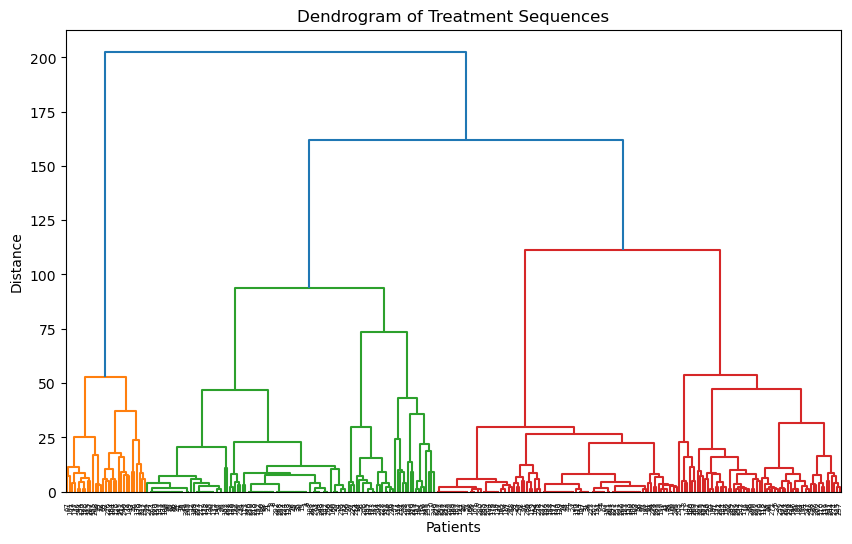

In [93]:
from scipy.spatial.distance import squareform

# Convert the distance matrix to a condensed distance matrix
condensed_distance_matrix_pdrs_lv = squareform(distance_matrix_pdrs_lv)

linkage_matrix_pdrs_lv = linkage(condensed_distance_matrix_pdrs_lv, method='ward')#, optimal_ordering=True)

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_pdrs_lv)
plt.title('Dendrogram of Treatment Sequences')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

In [94]:
c, coph_dists = cophenet(linkage_matrix_pdrs_lv, condensed_distance_matrix_pdrs_lv)
c

0.6852090048871086

In [96]:
drug_mapping = {"D":2, "C":4, "T":6, "S":8}
df_subsets_numeriques = pivoted_data_random_sample.replace(drug_mapping)
data_array_pd_nw = df_subsets_numeriques.to_numpy()

leaves_order_pd_nw = list(hierarchy.leaves_list(linkage_matrix_pdrs_lv))
data_array_pd_nw_order = data_array_pd_nw[leaves_order_pd_nw]

colors = ['blue', 'orange', 'green', 'red']
heatmap_nw = go.Heatmap(z=data_array_pd_nw_order, colorscale= 'viridis')

# Créer une figure
fig = go.Figure(data=heatmap_nw)
fig.update_layout(
    title='TCA with Levenshtein Distance',
    xaxis_title='Temps',
    yaxis_title='Patients',
)

# Afficher le graphique
fig.show()

### Avec la méthode Optimal Matching (algo Needleman-Wunsch)

In [115]:
substitution_matrix

-    C    D    S    T
-  0.0  1.0  1.0  1.0  1.0
C  1.0  0.0  1.0  1.0  1.0
D  1.0  1.0  0.0  3.0  2.0
S  1.0  1.0  3.0  0.0  1.0
T  1.0  1.0  2.0  1.0  0.0

In [102]:
def needleman_wunsch_custom(seq1, seq2, gap_penalty=-2):
    m, n = len(seq1), len(seq2)
    score_matrix = np.zeros((m+1, n+1))
    
    # Initialisation de la matrice de scores
    score_matrix[:, 0] = gap_penalty * np.arange(m+1)
    score_matrix[0, :] = gap_penalty * np.arange(n+1)

    for i in range(1, m+1):
        for j in range(1, n+1):
            match = score_matrix[i-1, j-1] + substitution_matrix.loc[seq1[i-1], seq2[j-1]]
            delete = score_matrix[i-1, j] + gap_penalty
            insert = score_matrix[i, j-1] + gap_penalty
            score_matrix[i, j] = max(match, delete, insert)

    # Score d'alignement optimal
    optimal_score = score_matrix[m, n]

    return optimal_score

In [35]:
# def needleman_wunsch(seq1, seq2, match_score=1, mismatch_score=-1, gap_penalty=-2):
#     m, n = len(seq1), len(seq2)
#     score_matrix = np.zeros((m+1, n+1))
    
#     # Initialisation de la matrice de scores
#     score_matrix[:, 0] = gap_penalty * np.arange(m+1)
#     score_matrix[0, :] = gap_penalty * np.arange(n+1)

#     # # Remplissage de la matrice de scores
#     # match_mismatch = np.vectorize(lambda x, y: match_score if x == y else mismatch_score)
#     # seq1_matrix = np.tile(seq1, (n, 1)).T
#     # seq2_matrix = np.tile(seq2, (m, 1))
#     # match_mismatch_matrix = match_mismatch(seq1_matrix, seq2_matrix)
    

#     for i in range(1, m+1):
#         for j in range(1, n+1):
#             match = score_matrix[i-1, j-1] + substitution_matrix[i-1, j-1]
#             delete = score_matrix[i-1, j] + gap_penalty
#             insert = score_matrix[i, j-1] + gap_penalty
#             score_matrix[i, j] = max(match, delete, insert)

#     # Score d'alignement optimal
#     optimal_score = score_matrix[m, n]

#     return optimal_score

In [99]:
distance_matrix_pdrs_nw = np.zeros((len(pivoted_data_random_sample), len(pivoted_data_random_sample)))
print(distance_matrix_pdrs_nw.shape)

# pivoted_data_random_sample.drop(['Sequence'], axis=1).iloc[0].dropna().values

# Convert the sequences to a NumPy array for faster processing
sequences = pivoted_data_random_sample.drop(['Sequence'], axis=1).apply(lambda x: x.dropna().values, axis=1).to_numpy()
print(len(sequences))

(300, 300)
300


In [117]:
for i in range(len(sequences)):

    for j in range(i + 1, len(sequences)):

        seq1, seq2 = sequences[i], sequences[j]
        print('seq1:', seq1)
        print('seq2:', seq2)

        # key = (tuple(seq1), tuple(seq2))
        # if key not in score_cache:

        m, n = len(seq1), len(seq2)
        score_matrix = np.zeros((m+1, n+1))

        # Initialisation de la matrice de scores
        score_matrix[:, 0] = gap_penalty * np.arange(m+1)
        score_matrix[0, :] = gap_penalty * np.arange(n+1)

        print('\nscore_matrix:\n', score_matrix)  

        print('\nsubstitution_matrix:\n', substitution_matrix)

        for i in range(1, m+1):
            for j in range(1, n+1):
                match = score_matrix[i-1, j-1] + substitution_matrix.loc[seq1[i-1], seq2[j-1]]
                print('score_matrix[i-1, j-1]:\n', score_matrix[i-1, j-1])
                print('substitution_matrix.loc[seq1[i-1], seq2[j-1]]:\n', substitution_matrix.loc[seq1[i-1], seq2[j-1]])
                delete = score_matrix[i-1, j] + gap_penalty
                insert = score_matrix[i, j-1] + gap_penalty
                score_matrix[i, j] = max(match, delete, insert)
                

        print('score_matrix:\n', score_matrix)
        # Score d'alignement optimal
        optimal_score = score_matrix[m, n]

        print('optimal_score:', optimal_score)  


        break

    
    break

seq1: ['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
seq2: ['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']

score_matrix:
 [[  0.  -2.  -4.  -6.  -8. -10. -12. -14. -16. -18. -20. -22. -24.]
 [ -2.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -4.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -6.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -8.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-10.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-12.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-14.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-16.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-18.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-20.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-22.   0.   0.   0.   0.   0.   0

In [110]:
gap_penalty = -2

# Create a dictionary to store the precomputed scores
score_cache = {}

start_time = timeit.default_timer()

for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        if key not in score_cache:
            score_cache[key] = needleman_wunsch_custom(seq1, seq2, gap_penalty)

# Fill the distance matrix using the precomputed scores
for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        # optimal_score = score_cache[key]
        # max_length = max(len(seq1), len(seq2))
        # normalized_score = optimal_score / max_length
        # distance = 1 - normalized_score
        distance = 1 - score_cache[key]
        distance_matrix_pdrs_nw[i, j] = distance
        distance_matrix_pdrs_nw[j, i] = distance  # Symmetric matrix

c_time = timeit.default_timer() - start_time
print(f"Time taken for computation: {c_time:.2f} seconds")            

Time taken for computation: 34.88 seconds


In [111]:
distance_matrix_pdrs_nw

array([[  0.,  33.,  30., ...,  -6., -13., -40.],
       [ 33.,   0.,   3., ..., -18., -12.,  -9.],
       [ 30.,   3.,   0., ..., -21., -15., -14.],
       ...,
       [ -6., -18., -21., ...,   0.,  -6.,  -3.],
       [-13., -12., -15., ...,  -6.,   0., -20.],
       [-40.,  -9., -14., ...,  -3., -20.,   0.]])

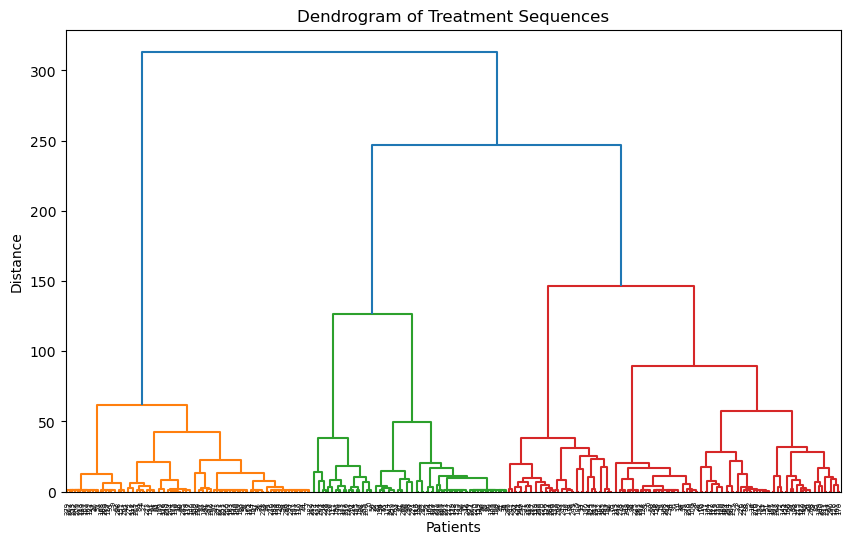

In [112]:
# Convert the distance matrix to a condensed distance matrix
condensed_distance_matrix_pdrs_nw = squareform(np.abs(distance_matrix_pdrs_nw))

linkage_matrix_pdrs_nw = linkage(condensed_distance_matrix_pdrs_nw, method='ward')#, optimal_ordering=True)

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_pdrs_nw)
plt.title('Dendrogram of Treatment Sequences')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

In [113]:
c, coph_dists = cophenet(linkage_matrix_pdrs_nw, condensed_distance_matrix_pdrs_nw)
c

0.43696325416407034

In [114]:
drug_mapping = {"D":2, "C":4, "T":6, "S":8}
df_subsets_numeriques = pivoted_data_random_sample.replace(drug_mapping)
data_array_pd_nw = df_subsets_numeriques.to_numpy()

leaves_order_pd_nw = list(hierarchy.leaves_list(linkage_matrix_pdrs_nw))
data_array_pd_nw_order = data_array_pd_nw[leaves_order_pd_nw]

colors = ['blue', 'orange', 'green', 'red']
heatmap_nw = go.Heatmap(z=data_array_pd_nw_order, colorscale= 'viridis')

# Créer une figure
fig = go.Figure(data=heatmap_nw)
fig.update_layout(
    title='TCA with Needleman-Wusnch Distance',
    xaxis_title='Temps',
    yaxis_title='Patients',
)

# Afficher le graphique
fig.show()

In [18]:
for i in range(len(sequences)):

    for j in range(i + 1, len(sequences)):

        seq1, seq2 = sequences[i], sequences[j]
        print('seq1:', seq1)
        print('seq2:', seq2)

        # key = (tuple(seq1), tuple(seq2))
        # if key not in score_cache:

        m, n = len(seq1), len(seq2)
        score_matrix = np.zeros((m+1, n+1))

        # Initialisation de la matrice de scores
        score_matrix[:, 0] = gap_penalty * np.arange(m+1)
        score_matrix[0, :] = gap_penalty * np.arange(n+1)

        print('score_matrix:\n', score_matrix)  

        # Remplissage de la matrice de scores
        match_mismatch = np.vectorize(lambda x, y: match_score if x == y else mismatch_score)
        seq1_matrix = np.tile(seq1, (n, 1)).T
        seq2_matrix = np.tile(seq2, (m, 1))
        match_mismatch_matrix = match_mismatch(seq1_matrix, seq2_matrix)

        print('match_mismatch_matrix:\n', match_mismatch_matrix)
        
        # Vectorized filling of the score matrix
        for i in range(1, m+1):

            match = score_matrix[i-1, :-1] + match_mismatch_matrix
            print('match:', match)
            delete = score_matrix[i-1, 1:] + gap_penalty
            print('delete:', delete)
            insert = score_matrix[i, :-1] + gap_penalty
            print('insert:', insert)

            score_matrix[i, 1:] = np.max(np.vstack((match, delete, insert)), axis=0)

        print('score_matrix:\n', score_matrix)
        # Score d'alignement optimal
        optimal_score = score_matrix[m, n]

        print('optimal_score:', optimal_score)  


        break

    
    break

seq1: ['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D']
seq2: ['D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'T']
score_matrix:
 [[  0.  -2.  -4.  -6.  -8. -10. -12. -14. -16. -18.]
 [ -2.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -4.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -6.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -8.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-10.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-12.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-14.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-16.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-18.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-20.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-22.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-24.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-26.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-28.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-30.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-32.   0.  

In [12]:
start_time = timeit.default_timer()

for i in range(len(sequences)):

    for j in range(i + 1, len(sequences)):

        seq1, seq2 = sequences[i], sequences[j]

        # key = (tuple(seq1), tuple(seq2))
        # if key not in score_cache:

        m, n = len(seq1), len(seq2)
        score_matrix = np.zeros((m+1, n+1))

        # Initialisation de la matrice de scores
        score_matrix[:, 0] = gap_penalty * np.arange(m+1)
        score_matrix[0, :] = gap_penalty * np.arange(n+1)


        # Remplissage de la matrice de scores
        match_mismatch = np.vectorize(lambda x, y: match_score if x == y else mismatch_score)
        seq1_matrix = np.tile(seq1, (n, 1)).T
        seq2_matrix = np.tile(seq2, (m, 1))
        match_mismatch_matrix = match_mismatch(seq1_matrix, seq2_matrix)


        for i in range(1, m+1):
            for j in range(1, n+1):
                match = score_matrix[i-1, j-1] + match_mismatch_matrix[i-1, j-1]
                delete = score_matrix[i-1, j] + gap_penalty
                insert = score_matrix[i, j-1] + gap_penalty
                score_matrix[i, j] = max(match, delete, insert)

        # Score d'alignement optimal
        optimal_score = score_matrix[m, n]




ttime = timeit.default_timer() - start_time
print(f"Time taken for computation: {ttime:.2f} seconds")

Time taken for computation: 11.86 seconds


In [13]:
start_time = timeit.default_timer()

for i in range(len(sequences)):

    for j in range(i + 1, len(sequences)):

        seq1, seq2 = sequences[i], sequences[j]

        # key = (tuple(seq1), tuple(seq2))
        # if key not in score_cache:

        m, n = len(seq1), len(seq2)
        score_matrix = np.zeros((m+1, n+1))

        # Initialisation de la matrice de scores
        score_matrix[:, 0] = gap_penalty * np.arange(m+1)
        score_matrix[0, :] = gap_penalty * np.arange(n+1)


        # Remplissage de la matrice de scores
        match_mismatch = np.vectorize(lambda x, y: match_score if x == y else mismatch_score)
        seq1_matrix = np.tile(seq1, (n, 1)).T
        seq2_matrix = np.tile(seq2, (m, 1))
        match_mismatch_matrix = match_mismatch(seq1_matrix, seq2_matrix)


        # Vectorized filling of the score matrix
        match = score_matrix[:-1, :-1] + match_mismatch_matrix
        delete = score_matrix[:-1, 1:] + gap_penalty
        insert = score_matrix[1:, :-1] + gap_penalty

        score_matrix[1:, 1:] = np.maximum.reduce([match, delete, insert])

        # Score d'alignement optimal
        optimal_score = score_matrix[m, n]




ttime = timeit.default_timer() - start_time
print(f"Time taken for computation: {ttime:.2f} seconds")

Time taken for computation: 2.08 seconds


In [71]:
start_time = timeit.default_timer()

# Convert the sequences to a numpy array for faster processing
# sequences = pivoted_data_random_sample.drop(['Sequence'], axis=1).apply(lambda x: x.dropna().values, axis=1).to_numpy()

# Precompute the match/mismatch scores for all possible pairs
match_score = 1
mismatch_score = -1
gap_penalty = -2

# Create a dictionary to store the precomputed scores
score_cache = {}

for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        if key not in score_cache:
            score_cache[key] = needleman_wunsch(seq1, seq2, match_score, mismatch_score, gap_penalty)

# Fill the distance matrix using the precomputed scores
for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        optimal_score = score_cache[key]
        max_length = max(len(seq1), len(seq2))
        normalized_score = optimal_score / max_length
        distance = 1 - normalized_score
        distance_matrix_pdrs_nw[i, j] = distance
        distance_matrix_pdrs_nw[j, i] = distance  # Symmetric matrix

elapsed_time = timeit.default_timer() - start_time
elapsed_time_list.append(elapsed_time)
print(f"Time taken for computation: {elapsed_time:.2f} seconds")

Time taken for computation: 5.91 seconds


In [74]:
distance_matrix_pd_nw = np.zeros((len(pivoted_data), len(pivoted_data)))
distance_matrix_pd_nw.shape

# Convert the sequences to a numpy array for faster processing
sequences = pivoted_data.apply(lambda x: x.dropna().values, axis=1).to_numpy()

# Precompute the match/mismatch scores for all possible pairs
match_score = 1
mismatch_score = -1
gap_penalty = -2

# Create a dictionary to store the precomputed scores
score_cache = {}

for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        if key not in score_cache:
            score_cache[key] = needleman_wunsch(seq1, seq2, match_score, mismatch_score, gap_penalty)

# Fill the distance matrix using the precomputed scores
for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        optimal_score = score_cache[key]
        max_length = max(len(seq1), len(seq2))
        normalized_score = optimal_score / max_length
        distance = 1 - normalized_score
        distance_matrix_pd_nw[i, j] = distance
        distance_matrix_pd_nw[j, i] = distance  # Symmetric matrix

computation_time = timeit.default_timer() - start_time
print(f"Time taken for computation: {computation_time:.2f} seconds")


Time taken for computation: 653.12 seconds


In [108]:
sequences = pivoted_data.apply(lambda x: x.dropna().values, axis=1).to_numpy()

# Create a dictionary to store the precomputed scores
score_cache = {}

for i in range(len(sequences)):
    for j in range(i + 1, len(sequences)):
        seq1, seq2 = sequences[i], sequences[j]
        key = (tuple(seq1), tuple(seq2))
        print('\nkey', key)

        if key not in score_cache:
            m, n = len(seq1), len(seq2)
            score_matrix = np.zeros((m+1, n+1))

            # Initialisation de la matrice de scores
            score_matrix[:, 0] = gap_penalty * np.arange(m+1)
            score_matrix[0, :] = gap_penalty * np.arange(n+1)
            print('\nscore_matrix\n', score_matrix) 

            # Remplissage de la matrice de scores
            match_mismatch = np.vectorize(lambda x, y: match_score if x == y else mismatch_score)
            seq1_matrix = np.tile(seq1, (n, 1)).T
            seq2_matrix = np.tile(seq2, (m, 1))
            match_mismatch_matrix = match_mismatch(seq1_matrix, seq2_matrix)
            print('\nmatch_mismatch_matrix\n', match_mismatch_matrix)

            # for i in range(1, m+1):
            #     for j in range(1, n+1):
            #         match = score_matrix[i-1, j-1] + match_mismatch_matrix[i-1, j-1]
            #         delete = score_matrix[i-1, j] + gap_penalty
            #         insert = score_matrix[i, j-1] + gap_penalty
            #         score_matrix[i, j] = max(match, delete, insert)

            # # Score d'alignement optimal
            # optimal_score = score_matrix[m, n]
            # score_cache[key] = optimal_score

    break        


key (('D', 'D', 'D', 'D', 'D', 'D'), ('D', 'D'))

score_matrix
 [[  0.  -2.  -4.]
 [ -2.   0.   0.]
 [ -4.   0.   0.]
 [ -6.   0.   0.]
 [ -8.   0.   0.]
 [-10.   0.   0.]
 [-12.   0.   0.]]

match_mismatch_matrix
 [[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]]

key (('D', 'D', 'D', 'D', 'D', 'D'), ('D', 'D', 'D', 'D', 'D', 'D', 'D', 'D'))

score_matrix
 [[  0.  -2.  -4.  -6.  -8. -10. -12. -14. -16.]
 [ -2.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -4.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -6.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ -8.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-10.   0.   0.   0.   0.   0.   0.   0.   0.]
 [-12.   0.   0.   0.   0.   0.   0.   0.   0.]]

match_mismatch_matrix
 [[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]]

key (('D', 'D', 'D', 'D', 'D', 'D'), ('D', 'D', 'D', 'D', 'T', 'T', 'T', 'C', 'D', 'D', 'D', 'D', 'D', 'D', 'D', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'T', 'T', '

C:\Users\nicolas.grevet\AppData\Local\Temp\ipykernel_3724\371686110.py:1: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



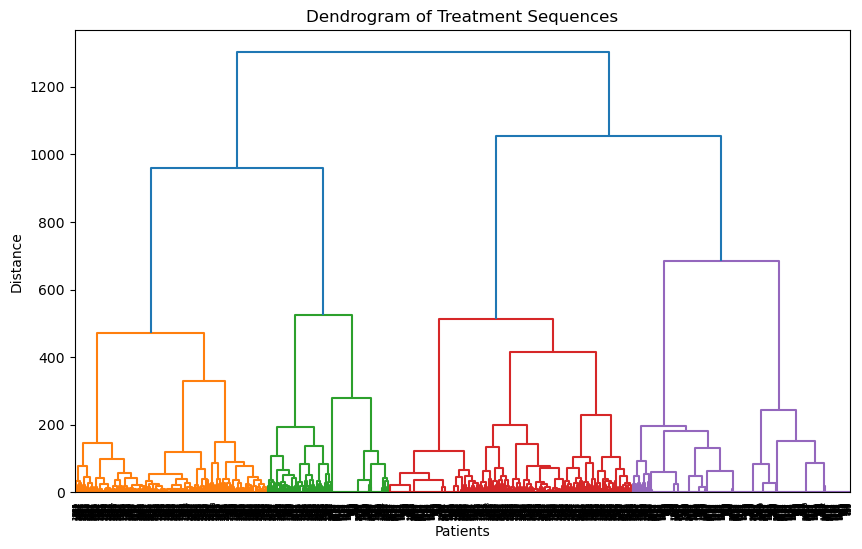

In [81]:
linkage_matrix_pd_nw = linkage(np.abs(distance_matrix_pd_nw), method='ward')#, optimal_ordering=True)

plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix_pd_nw)
plt.title('Dendrogram of Treatment Sequences')
plt.xlabel('Patients')
plt.ylabel('Distance')
plt.show()

In [85]:
linkage_matrix_pd_nw

array([[0.00000000e+00, 5.00000000e+00, 0.00000000e+00, 2.00000000e+00],
       [1.00000000e+00, 2.30000000e+01, 0.00000000e+00, 2.00000000e+00],
       [2.00000000e+00, 1.28000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [5.85000000e+03, 5.85200000e+03, 9.60168446e+02, 1.19100000e+03],
       [5.85100000e+03, 5.85300000e+03, 1.05569491e+03, 1.73800000e+03],
       [5.85400000e+03, 5.85500000e+03, 1.30227651e+03, 2.92900000e+03]])

In [84]:
c, coph_dists = cophenet(linkage_matrix_pd_nw, np.abs(distance_matrix_pd_nw))
c

ValueError: Condensed distance matrix 'Y' must have shape=1 (i.e. be one-dimensional).

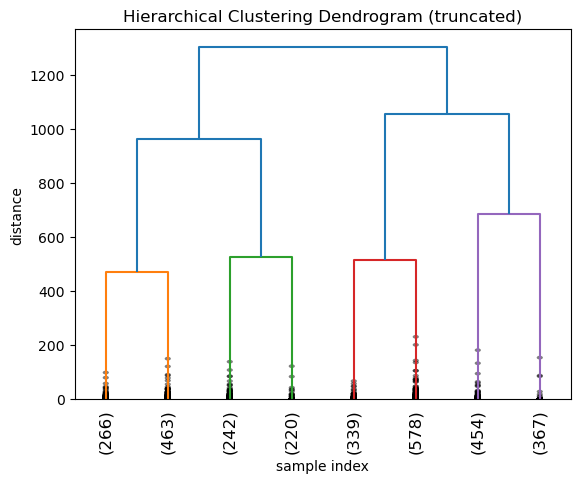

In [86]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    linkage_matrix_pd_nw,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=8,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()


In [98]:
from scipy.cluster.hierarchy import fcluster

max_d = 400
clusters = fcluster(linkage_matrix_pd_nw, max_d, criterion='distance')

results1 = pivoted_data.copy()
results1['cluster'] = clusters
results1 = results1[['cluster'] + [col for col in results1.columns if col != 'cluster']]

results1

cluster month_1 month_2 month_3 month_4 month_5 month_6 month_7 month_8  \
id                                                                              
3           9       D       D       D       D       D       D     NaN     NaN   
9           4       D       D     NaN     NaN     NaN     NaN     NaN     NaN   
13          9       D       D       D       D       D       D       D       D   
15          6       D       D       D       D       T       T       T       C   
18          2       D       D       S       S       S       S       S       S   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
9986        4       D       D     NaN     NaN     NaN     NaN     NaN     NaN   
9988        1       D       C       C       T       T       T       T       T   
9989        2       D       C       T       T       S       S       S       S   
9996        2       D       C       C       C       C       C       C       T   
9998        2       D       D       D       C       T       T       S       S   

     month_9  ... month_42 month_43 month_44 month_45 month_46 month_47  \
id            ...                                                         
3        NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9        NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
13       NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
15         D  ...      NaN      NaN      NaN      NaN      NaN      NaN   
18         S  ...      NaN      NaN      NaN      NaN      NaN      NaN   
...      ...  ...      ...      ...      ...      ...      ...      ...   
9986     NaN  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9988       T  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9989       S  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9996       T  ...      NaN      NaN      NaN      NaN      NaN      NaN   
9998       S  ...      NaN      NaN      NaN      NaN      NaN      NaN   

     month_48 month_49 month_50 month_51  
id                                        
3         NaN      NaN      NaN      NaN  
9         NaN      NaN      NaN      NaN  
13        NaN      NaN      NaN      NaN  
15        NaN      NaN      NaN      NaN  
18        NaN      NaN      NaN      NaN  
...       ...      ...      ...      ...  
9986      NaN      NaN      NaN      NaN  
9988      NaN      NaN      NaN      NaN  
9989      NaN      NaN      NaN      NaN  
9996      NaN      NaN      NaN      NaN  
9998      NaN      NaN      NaN      NaN  

[2929 rows x 52 columns]

In [99]:
results1['cluster'].value_counts()

cluster
2    463
8    454
9    367
5    339
6    321
1    266
7    257
3    242
4    220
Name: count, dtype: int64

In [102]:
len(data_array_pd_nw)

2929

In [101]:
len(leaves_order_pd_nw)

2929

In [103]:
data_array_pd_nw_order

array([['D', 'C', 'C', ..., nan, nan, nan],
       ['D', 'D', 'D', ..., nan, nan, nan],
       ['D', 'C', 'C', ..., nan, nan, nan],
       ...,
       ['D', 'D', 'D', ..., nan, nan, nan],
       ['D', 'D', 'D', ..., nan, nan, nan],
       ['D', 'D', 'D', ..., nan, nan, nan]], dtype=object)

In [104]:
drug_mapping = {"D":2, "C":4, "T":6, "S":8}
df_subsets_numeriques = pivoted_data.replace(drug_mapping)
df_subsets_numeriques

data_array_pd_nw = df_subsets_numeriques.to_numpy()

leaves_order_pd_nw = list(hierarchy.leaves_list(linkage_matrix_pd_nw))
data_array_pd_nw_order = data_array_pd_nw[leaves_order_pd_nw]

colors = ['blue', 'orange', 'green', 'red']
heatmap_nw = go.Heatmap(z=data_array_pd_nw_order, colorscale= 'viridis')

# Créer une figure
fig = go.Figure(data=heatmap_nw)
fig.update_layout(
    title='TCA with Optimal Matching Distance',
    xaxis_title='Temps',
    yaxis_title='Patients',
)

# Afficher le graphique
fig.show()

_____